In [26]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

FOLDERNAME = 'Deep_Learning_Udemy/a5_Mini_ResNet-16'

assert FOLDERNAME is not None, "[!] Enter the foldername."

%cd drive/My\ Drive
%cp -r $FOLDERNAME ../../
%cd ../../



Mounted at /content/drive
/content/drive/My Drive
/content


##Import Libraries

In [0]:
import torch 
import torch.nn as nn
import torchvision 
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Loading CIFAR-10 dataset

In [28]:
# Device Configurations
device  = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
num_epochs = 30
batch_size = 100
learning_rate = 0.001

# Image processing modules
transform = transforms.Compose([transforms.Pad(4),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.RandomCrop(32),
                                 transforms.ToTensor()])

# CIFER-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='../../data/', 
                                             train=True, 
                                             transform=transform, 
                                             download=True)
test_dataset = torchvision.datasets.CIFAR10(root='../../data/', 
                                             train=False, 
                                             transform=transforms.ToTensor())

# Data Loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

# Classes
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified


## Defining function for 3*3 filter CNN and Defining Class for Residual Block

In [0]:
# Convolution Network of kernal size 3x3
def conv3x3(in_channels, out_channels, stride = 1):
  return nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=stride, padding=1, bias=False)

#Residual Block
class ResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels, stride = 1, downsampling=None):
    super(ResidualBlock, self).__init__()
    self.conv1 = conv3x3(in_channels, out_channels,stride)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.relu = nn.ReLU(inplace=True)
    self.conv2 = conv3x3(out_channels, out_channels)
    self.bn2 = nn.BatchNorm2d(out_channels)
    self.downsampling = downsampling
  
  def forward(self, x):
    residual = x
    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)
    out = self.conv2(out)
    out = self.bn2(out)
    
    if self.downsampling:
      residual = self.downsampling(x)
    out += residual
    out = self.relu(out)
    return out



## ResNet Class

In [0]:
class ResNet(nn.Module):
  def __init__(self, block, layers, num_classes=10):
    super(ResNet, self).__init__()
    self.in_channels = 16
    self.conv = conv3x3(3,16)
    self.bn = nn.BatchNorm2d(16)
    self.relu = nn.ReLU(inplace=True)

    #layers will be list--------------> layers = [2,2,2] where 2 is block(residual block)
    self.layer1 = self.make_layer(block, 16, layers[0], stride=1) # First layer contains 2 Residual Block (Residual Block contain 16 kernal of size 3x3 )
    self.layer2 = self.make_layer(block, 32, layers[1], stride=2) # Second layer contains 2 Residual Block (Residual Block contain 32 kernal of size 3x3 ) 
    self.layer3 = self.make_layer(block, 64, layers[2], stride=2) # Third layer contains 2 Residual Block (Residual Block contain 64 kernal of size 3x3 )
    self.avg_pool = nn.AvgPool2d(kernel_size=8)
    self.fc = nn.Linear(in_features=64, out_features=num_classes)

  # Defining make_layer function 
  # used create 2 residual block each time and also downsample image after each 2 residual blocks
  # here we are using Stride of 2 to downsample image instead of maxpooing of 2x2 because some important features are lost during maxpooling
  def make_layer(self, block, out_channels, blocks, stride = 1):
    downsampling = None
    if (self.in_channels != out_channels) or (stride != 1):
      downsampling = nn.Sequential(conv3x3(self.in_channels, out_channels, stride=stride), 
                                   nn.BatchNorm2d(out_channels))
    residual_block = []
    residual_block.append(block(self.in_channels, out_channels, stride = stride, downsampling=downsampling))
    self.in_channels = out_channels
    residual_block.append(block(self.in_channels, out_channels))
    return nn.Sequential(*residual_block)
  
  def forward(self, x):
    out = self.conv(x)
    out = self.bn(out)
    out = self.relu(out)
    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.avg_pool(out)
    out = out.view(out.size(0), -1)
    out = self.fc(out)
    return out

## Create object of ResNet Class
## Define a Loss function and optimizer

In [0]:
model = ResNet(ResidualBlock, [2,2,2]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Train the network

In [32]:
model.train()
decay = 0
train_losses=[]
train_acurracy=[]
for epoch in range (num_epochs):
  correct = 0
  iter_loss = 0

  # Decay the learning rate by a factor of 0.5 every 20 epochs
  if (epoch+1) % 20 == 0:
    decay +=1
    optimizer.param_groups[0]['lr'] = learning_rate * (0.5 ** decay)

  for i, (images, labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)
    output = model(images)
    loss = criterion(output, labels)
    iter_loss += loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # if (i+1) % 100 == 0:
    #   print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}".format(epoch+1, num_epochs, i+1, len(train_loader), loss.item()))

    _, predicted = torch.max(output, 1)
    correct += (predicted == labels).sum().item()
  
  train_acurracy.append(correct/len(train_dataset))
  train_losses.append(iter_loss/batch_size)

  print("Epoch: {}/{} Training Accuracy: {:.3f} Training Loss : {:.4f}".format(epoch+1, num_epochs, 100*train_acurracy[-1], train_losses[-1]))

  

Epoch: 1/30 Training Accuracy: 48.044 Training Loss : 7.0765
Epoch: 2/30 Training Accuracy: 63.650 Training Loss : 5.0873
Epoch: 3/30 Training Accuracy: 69.096 Training Loss : 4.3495
Epoch: 4/30 Training Accuracy: 72.846 Training Loss : 3.8366
Epoch: 5/30 Training Accuracy: 75.998 Training Loss : 3.4296
Epoch: 6/30 Training Accuracy: 78.126 Training Loss : 3.1446
Epoch: 7/30 Training Accuracy: 79.498 Training Loss : 2.9469
Epoch: 8/30 Training Accuracy: 80.612 Training Loss : 2.7769
Epoch: 9/30 Training Accuracy: 81.840 Training Loss : 2.6162
Epoch: 10/30 Training Accuracy: 82.598 Training Loss : 2.5087
Epoch: 11/30 Training Accuracy: 83.492 Training Loss : 2.3766
Epoch: 12/30 Training Accuracy: 84.064 Training Loss : 2.2924
Epoch: 13/30 Training Accuracy: 84.826 Training Loss : 2.1897
Epoch: 14/30 Training Accuracy: 85.296 Training Loss : 2.1127
Epoch: 15/30 Training Accuracy: 85.646 Training Loss : 2.0442
Epoch: 16/30 Training Accuracy: 86.484 Training Loss : 1.9530
Epoch: 17/30 Trai

## Let’s quickly save our trained model:

In [0]:
model_save_name = 'classifier.pt'
PATH = "/content/drive/My Drive/Deep_Learning_Udemy/a5_Mini_ResNet-16/{model_save_name}"
torch.save(model.state_dict(), PATH)

## Testing Network

In [37]:
model.eval()

with torch.no_grad():
  correct = 0
  total = 0
  for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    output = model(images)
    _, predicted = torch.max(output, 1)
    correct += (predicted == labels).sum().item()
    total += labels.size(0)
  print("Accuracy of the model on test images: {}". format(100* correct / total))

Accuracy of the model on test images: 86.38


In [35]:
from torchsummary import summary
summary(model,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 16, 32, 32]           2,304
       BatchNorm2d-5           [-1, 16, 32, 32]              32
              ReLU-6           [-1, 16, 32, 32]               0
            Conv2d-7           [-1, 16, 32, 32]           2,304
       BatchNorm2d-8           [-1, 16, 32, 32]              32
              ReLU-9           [-1, 16, 32, 32]               0
    ResidualBlock-10           [-1, 16, 32, 32]               0
           Conv2d-11           [-1, 16, 32, 32]           2,304
      BatchNorm2d-12           [-1, 16, 32, 32]              32
             ReLU-13           [-1, 16, 32, 32]               0
           Conv2d-14           [-1, 16,

## Test the network on the test data

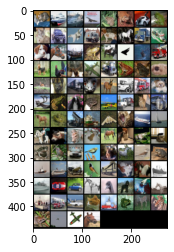

GroundTruth:    cat  ship  ship plane  frog  frog
Predicted:    cat  ship  ship  ship  frog  frog


In [36]:
# # Let's visualize image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random testing images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(6)))
images = images.to(device)
model = model.to(device)
output = model(images)
_, predicted = torch.max(output,1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(6)))
